In [1]:
!pip install torch torchvision torchaudio transformers pandas scikit-learn matplotlib seaborn


  Using cached torchvision-0.22.1-cp312-cp312-win_amd64.whl.metadata (6.1 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached torch-2.7.1-cp312-cp312-win_amd64.whl.metadata (28 kB)
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
  Using cached torchaudio-2.7.1-cp312-cp312-win_amd64.whl.metadata (6.6 kB)
Using cached torchvision-0.22.1-cp312-cp312-win_amd64.whl (1.7 MB)
Using cached torch-2.7.1-cp312-cp312-win_amd64.whl (216.1 MB)
Using cached torchaudio-2.7.1-cp312-cp312-win_amd64.whl (2.5 MB)

  Attempting uninstall: torch

    Found existing installation: torch 2.6.0

   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ------------

ERROR: Could not install packages due to an OSError: [Errno 28] No space left on device



In [3]:
!pip install pandas

In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report
from torch.nn.functional import softmax
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\62822\UAS_DML_KELOMPOK-A\.uas\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load CSV
df_labels = pd.read_csv("train_labels.csv")
df_articles = pd.read_csv("parsed_articles_train_clean.csv")

# Gabungkan data berdasarkan article_id
df = pd.merge(df_labels, df_articles, on="article_id", how="inner")

# Hapus label 'Missing'
df = df[df['type'] != 'Missing']
df['label'] = df['type'].map({'Primary': 0, 'Secondary': 1})

In [4]:
df.head()

,article_id,dataset_id,type,abstract,body,label
0,10.1002_2017jc013030,https://doi.org/10.17882/49388,Primary,NaN,NaN,0
12,10.1002_ece3.4466,https://doi.org/10.5061/dryad.r6nq870,Primary,Abstract Sex determination in Australian agami...,INTRODUCTION The fundamental biological proces...,0
13,10.1002_ece3.5260,https://doi.org/10.5061/dryad.2f62927,Primary,Abstract Targeted capture and enrichment appro...,INTRODUCTION The phylogenomics revolution is u...,0
15,10.1002_ece3.6144,https://doi.org/10.5061/dryad.zw3r22854,Primary,Abstract There is urgent need for effective an...,INTRODUCTION Marine ecosystems can change rapi...,0
16,10.1002_ece3.6303,https://doi.org/10.5061/dryad.37pvmcvgb,Primary,Abstract Polyploidy can cause variation in pla...,INTRODUCTION Invasions by exotic plant species...,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 618 entries, 0 to 841
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   article_id  618 non-null    object
 1   dataset_id  618 non-null    object
 2   type        618 non-null    object
 3   abstract    470 non-null    object
 4   body        468 non-null    object
 5   label       618 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 33.8+ KB


In [6]:
df.describe()

,label
count,618.000000
mean,0.684466
std,0.465105
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [7]:
df.duplicated().sum()

np.int64(0)

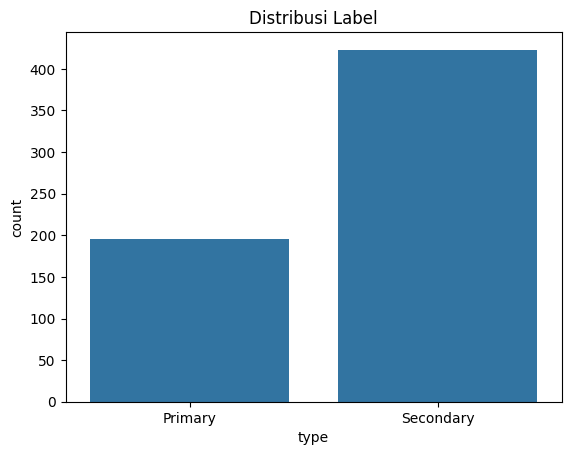

In [8]:
# Distribusi label
sns.countplot(x='type', data=df)
plt.title("Distribusi Label")
plt.show()

In [9]:
# Inisialisasi Tokenizer dari Hugging Face
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Ekstrak teks dan label dari DataFrame
texts = df['body'].fillna("").tolist()
labels = df['label'].tolist()

# Bagi data menjadi set pelatihan dan validasi sebelum tokenisasi
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

# Lakukan tokenisasi pada set pelatihan dan validasi secara terpisah
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512, return_tensors='pt')
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512, return_tensors='pt')

In [14]:
from torch.utils.data import Dataset
import torch

class NewsDataset(Dataset):
    def __init__(self, encodings, labels):  # dua garis bawah
        self.encodings = encodings
        self.labels = labels

    def __len__(self):  # dua garis bawah
        return len(self.labels)

    def __getitem__(self, idx):  # dua garis bawah
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [15]:
train_dataset = NewsDataset(train_encodings, train_labels)
val_dataset = NewsDataset(val_encodings, val_labels)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
